# Slope app function practice

In [1]:
# load everything needed
import gpxpy
import gpxpy.gpx
from geopy.distance import geodesic
import pandas as pd
import folium
import matplotlib.pyplot as plt

In [3]:
# save all runs basic data ex: lat, lon, ele, dis, ele_drop

file_path = "January 20, 2025 - Mt Naeba.gpx"

gpx_file = open(file_path, 'r')
gpx = gpxpy.parse(gpx_file)

tracks = {}

# first loop via all "segment" in the "track"

for track in gpx.tracks:
    for i, segment in enumerate(track.segments):
        # here i only extract out the start and end data
        start = segment.points[0]
        end  = segment.points[-1]

        tracks[i] = {
            "segment_id": i,
            "start_lat" : start.latitude,
            "start_lon" : start.longitude,
            "start_ele" : start.elevation,
            "end_lat" : end.latitude,
            "end_lon" : end.longitude,
            "end_ele" : end.elevation,
            "distance_mi" : geodesic((start.latitude, start.longitude), (end.latitude, end.longitude)).miles,
            "ele_drop": end.elevation - start.elevation
            }

# transfer tarcks into DF
df = pd.DataFrame.from_dict(tracks, orient = "index")

In [ ]:
df

# plot map and data visualization

In [4]:
# draw all the point on the map

# let's extarct out all the points and save it for folium.PolyLine()
# data needed looks like: [(lat1, lon1), (lat2, lon2), ..., (latN, lonN)]

segment_lines = {}

for track in gpx.tracks:
    for i, segment in enumerate(track.segments):
        segment_lines[i] = [(point.latitude, point.longitude) for point in segment.points]

# print(segment_lines)
# print(len(segment_lines))

# finding the center of the map by using the first and last point' location
loc_lat = 0
loc_lon = 0
for i in range((len(segment_lines))):
    loc_lat += segment_lines[i][0][0]
    loc_lon += segment_lines[i][0][1]

center_location = loc_lat/len(segment_lines), loc_lon/len(segment_lines)

# set map's center
map = folium.Map(location=center_location, tiles="OpenStreetMap", zoom_start=16)
map

for i in segment_lines:
    if df["ele_drop"][i] >= 0:
        folium.PolyLine(segment_lines[i], color="gray", weight=3, opacity=0.7).add_to(map)
    else:
        folium.PolyLine(segment_lines[i], color="red", weight=3, opacity=0.7).add_to(map)

In [ ]:
map

In [ ]:
# using pandass to draw plot, less control
# df['distance_mi'].plot(kind='line', figsize=(15, 10), fontsize=12, color = "orange", label='Distance (mi)')
# df['ele_drop'].plot(kind='bar', figsize=(15, 10),  fontsize=12, label='Elevation (m)')

# using matplotlib to plot, more control
fig = plt.figure()

ax1 = fig.add_subplot() # Create matplotlib axes
ax2 = ax1.twinx() 

line1 = ax1.plot(df['distance_mi'], label='Distance (mi)', color='orange')
bars = ax2.bar(df.index, df['ele_drop'], label='Elevation Drop (m)', color='blue')

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# nrow = 2, so one plot ont top and the other at bottom
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))

# first fig：distance (mi)
df['distance_mi'].plot(
    kind='line',
    ax=axes[0],
    title='Segment Distance',
    legend=False
)
axes[0].set_xlabel("Runs#")
axes[0].set_ylabel("Miles")

# fig two：elevation drop (m)
df['ele_drop'].plot(
    kind='bar',
    ax=axes[1],
    title='Elevation Drop',
    legend=False,
    color='orange'
)
axes[1].set_xlabel("Runs#")
axes[1].set_ylabel("Elevation Drop (m)")
axes[1].axhline(0, color='gray', linestyle='--')  # 0 drop line

plt.tight_layout() # tighten the layout
plt.show()


# try extact all points and put into PD data frame

In [4]:
data = []
for track in gpx.tracks:
    for i, segment in enumerate(track.segments):
        for point in segment.points:
        # here i only extract out the start and end data

            data.append( {
                "segment_id": i,
                "latitude" : point.latitude,
                "longitude" : point.longitude,
                "elevation" : point.elevation,
                "time": point.time
                # "distance_mi" : geodesic((start.latitude, start.longitude), (end.latitude, end.longitude)).miles,
                # "ele_drop": end.elevation - start.elevation
                })
            
all_points_df = pd.DataFrame(data)
all_points_df['time'] = pd.to_datetime(all_points_df['time'])  # transfer "time" into datetime format
all_points_df['time'] = all_points_df['time'].dt.tz_localize(None)  # get rid of timezone

# calculate the distance between two consecutive points
all_points_df['lat_prev'] = all_points_df["latitude"].shift(1)
all_points_df['lon_prev'] = all_points_df["longitude"].shift(1)
all_points_df['ele_prev'] = all_points_df["elevation"].shift(1)
all_points_df['time_prev'] = all_points_df['time'].shift(1)
all_points_df['segment_prev'] = all_points_df['segment_id'].shift(1)

def cal_dis(lat, lon, seg):
    geodesic((lat, lon), (end.latitude, end.longitude)).meters

In [5]:
# new 'time_diff(s)'
all_points_df['time_diff(s)'] = (all_points_df['time'] - all_points_df['time_prev']).dt.total_seconds()

# new 'distance_to_prev(m)'
def compute_distance(row):
    if row['segment_id'] != row['segment_prev']:
        return None
    return geodesic((row['latitude'], row['longitude']), (row['lat_prev'], row['lon_prev'])).meters

all_points_df['distance_to_prev(m)'] = all_points_df.apply(compute_distance, axis=1)

# new 'speed_m/s'
all_points_df['speed_m/s'] = all_points_df['distance_to_prev(m)'] / all_points_df['time_diff(s)']

# elevationdifferent 
# all_points_df['elevation_diff'] = all_points_df['elevation'] - all_points_df['ele_prev']

# test if the run is lift
segment_drop = (
    all_points_df.groupby('segment_id')
    .agg(start_ele=('elevation', 'first'), end_ele=('elevation', 'last'))
)

segment_drop['ele_drop'] = segment_drop['end_ele'] - segment_drop['start_ele']
segment_drop['is_lift'] = segment_drop['ele_drop'] > 0 
if "is_lift" not in all_points_df:
    all_points_df = all_points_df.merge(
        segment_drop['is_lift'],
        left_on='segment_id',
        right_index=True
    )


In [7]:
all_points_df.tail(5)
# all_points_df.head(5)

,segment_id,latitude,longitude,elevation,time,lat_prev,lon_prev,ele_prev,time_prev,segment_prev,time_diff(s),distance_to_prev(m),speed_m/s,is_lift
474,9,36.794359,138.784367,905.479275,2025-01-20 12:35:23,36.794257,138.784366,905.878558,2025-01-20 12:35:19,9.0,4.0,11.319679,2.829920,False
475,9,36.794341,138.784491,902.213047,2025-01-20 12:35:26,36.794359,138.784367,905.479275,2025-01-20 12:35:23,9.0,3.0,11.245926,3.748642,False
476,9,36.794440,138.784547,901.898613,2025-01-20 12:35:29,36.794341,138.784491,902.213047,2025-01-20 12:35:26,9.0,3.0,12.069861,4.023287,False
477,9,36.794513,138.784630,900.477755,2025-01-20 12:35:33,36.794440,138.784547,901.898613,2025-01-20 12:35:29,9.0,4.0,10.977395,2.744349,False
478,9,36.794534,138.784743,899.412050,2025-01-20 12:35:37,36.794513,138.784630,900.477755,2025-01-20 12:35:33,9.0,4.0,10.351071,2.587768,False


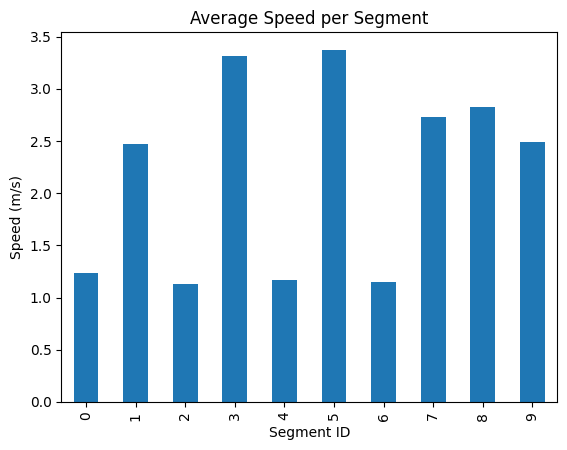

In [8]:
all_points_df.groupby('segment_id')['speed_m/s'].mean().plot(kind='bar')
plt.xlabel('Segment ID')
plt.ylabel('Speed (m/s)')
plt.title('Average Speed per Segment')
plt.show()

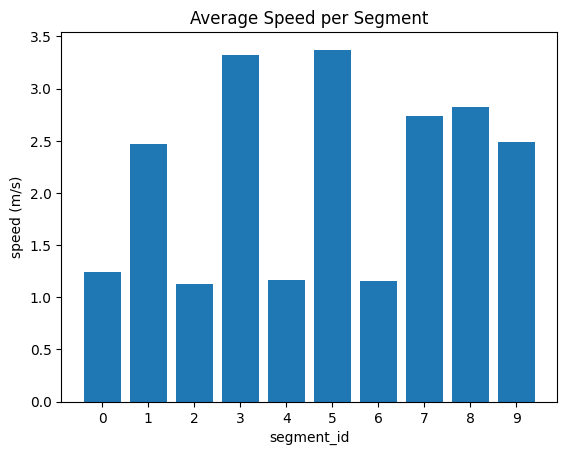

In [9]:
fig, ax = plt.subplots()
grouped = all_points_df.groupby('segment_id')['speed_m/s'].mean()
ax.bar(grouped.index, grouped.values)
ax.set_xlabel("segment_id")
ax.set_ylabel("speed (m/s)")
ax.set_title('Average Speed per Segment')
ax.set_xticks(grouped.index)
plt.show()


In [8]:
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import colormaps

In [9]:
min_speed = all_points_df['speed_m/s'].min()
max_speed = all_points_df['speed_m/s'].max()
norm = colors.Normalize(vmin=min_speed, vmax=max_speed)
cmap = colormaps.get_cmap('coolwarm')


In [10]:
# finding the center of the map by using the first and last point' location

center_location = sum(all_points_df["latitude"])/all_points_df.shape[0], sum(all_points_df["longitude"])/all_points_df.shape[0]

# set map's center
map = folium.Map(location=center_location, tiles="OpenStreetMap", zoom_start=16)


# #############

for i in range(1, len(all_points_df)):
    if all_points_df.loc[i, 'segment_id'] != all_points_df.loc[i-1, 'segment_id']:
        continue

    p1 = (all_points_df.loc[i-1, "latitude"], all_points_df.loc[i-1, "longitude"])
    p2 = (all_points_df.loc[i, "latitude"], all_points_df.loc[i, "longitude"])
    speed = all_points_df.loc[i, 'speed_m/s']
    color_rgb = cmap(norm(speed))
    color_hex = colors.to_hex(color_rgb)
    if all_points_df["is_lift"][i]:
        folium.PolyLine([p1, p2], color="gray", weight=4).add_to(map)
    else:
        folium.PolyLine([p1, p2], color=color_hex, weight=4).add_to(map)


In [11]:
map

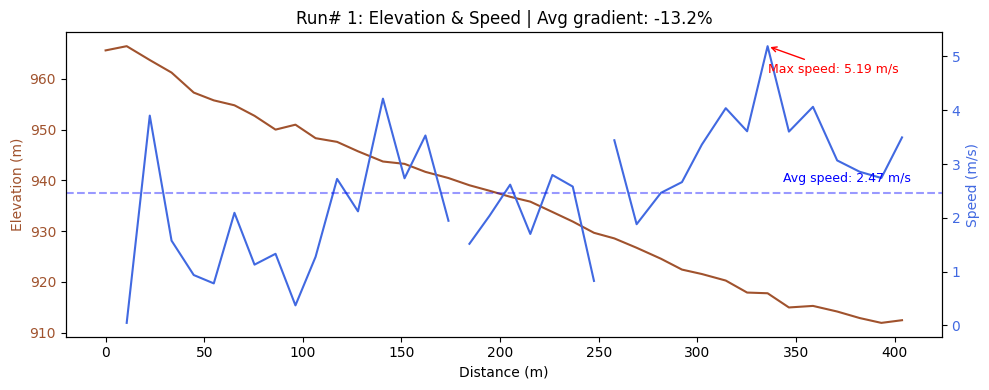

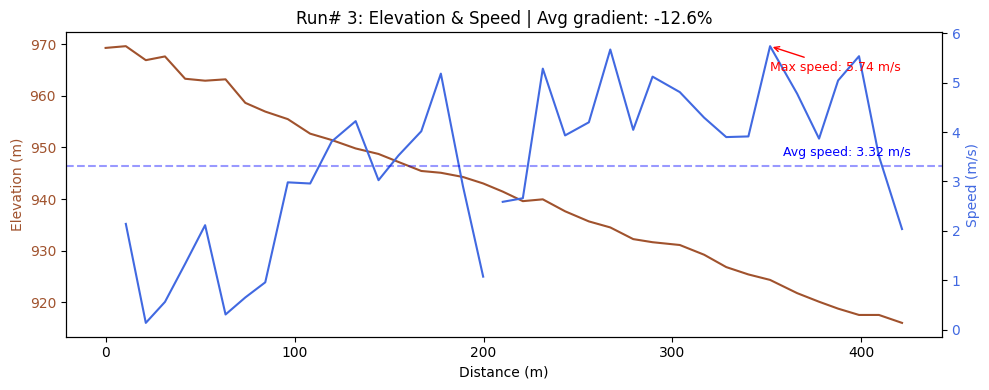

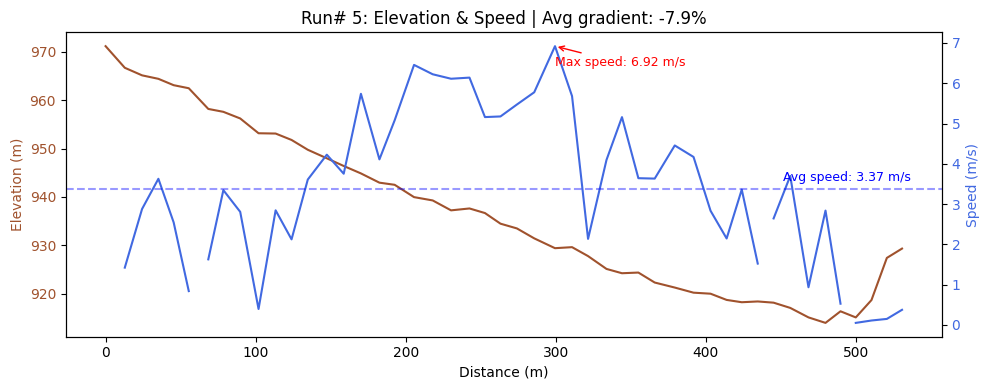

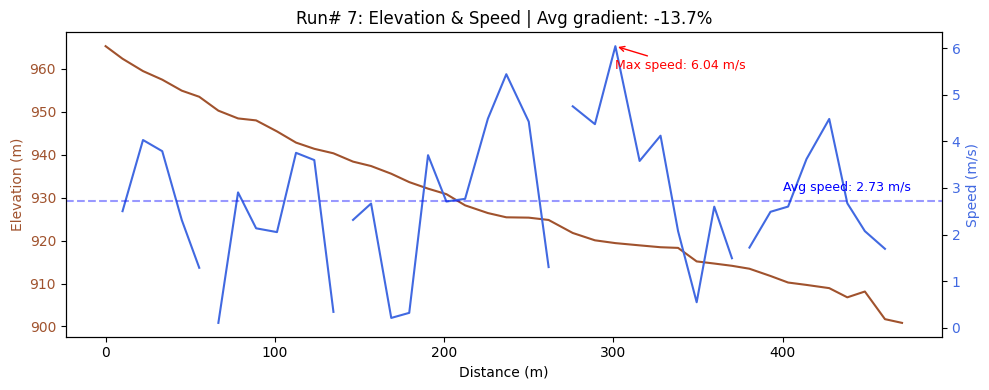

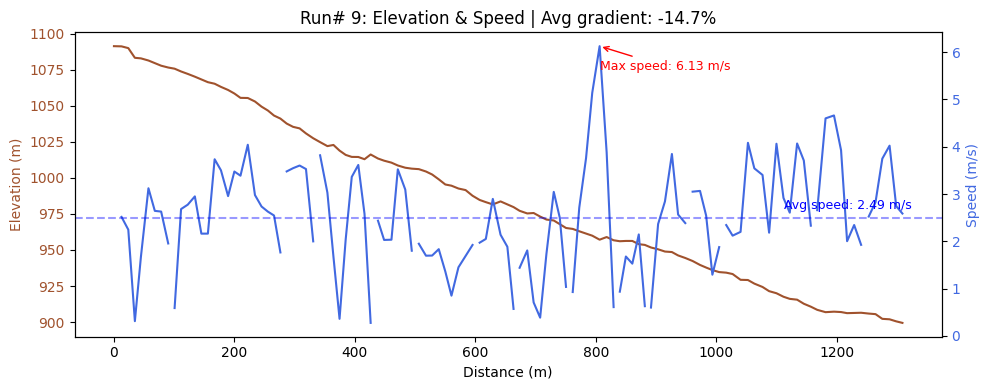

In [12]:
# elevation and speed

# filter the runs / exclude the lift time
df = all_points_df[~all_points_df['is_lift']].copy()
for segment_id, seg_df in df.groupby('segment_id'):
    # calculate each run's total_distance
    seg_df = seg_df.copy()  # aovid SettingWithCopyWarning
    seg_df['total_distance'] = seg_df['distance_to_prev(m)'].fillna(0).cumsum()

    # calculate the avg_gradient
    start_ele = seg_df['elevation'].iloc[0]
    end_ele = seg_df['elevation'].iloc[-1]
    ele_drop = end_ele - start_ele
    total_distance = seg_df['distance_to_prev(m)'].fillna(0).sum()
    # print(ele_drop)
    # print(total_distance)
    avg_gradient = (ele_drop / total_distance) * 100 if total_distance != 0 else 0
    # print(avg_gradient)

    # get the max spped
    max_speed_idx = seg_df['speed_m/s'].idxmax()
    max_speed = seg_df.loc[max_speed_idx, 'speed_m/s']
    max_speed_x = seg_df.loc[max_speed_idx, 'total_distance']

    # avg_spped
    avg_speed = avg_speed = seg_df['speed_m/s'].mean()
    avg_speed = round(avg_speed, 2)
    
    # create the plot
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # let y_aix：Elevation
    ax1.plot(seg_df['total_distance'], seg_df['elevation'], color='sienna')
    ax1.set_ylabel("Elevation (m)", color='sienna')
    ax1.tick_params(axis='y', labelcolor='sienna')

    # right y_aix：Speed
    ax2 = ax1.twinx()
    ax2.plot(seg_df['total_distance'], seg_df['speed_m/s'], color='royalblue')
    ax2.set_ylabel("Speed (m/s)", color='royalblue')
    ax2.tick_params(axis='y', labelcolor='royalblue')
    ax2.axhline(avg_speed, color='blue', linestyle='--', alpha=0.4)
    ax2.text(
    x=seg_df['total_distance'].max()* 0.85 ,  # 靠左一點
    y=avg_speed + 0.2,                        # 緊貼虛線上方
    s=f"Avg speed: {avg_speed:.2f} m/s",
    fontsize=9,
    color='blue')

    ax2.annotate(f"Max speed: {max_speed:.2f} m/s", 
             xy=(max_speed_x, max_speed),
             xytext=(max_speed_x, max_speed - 0.5),
             arrowprops=dict(arrowstyle='->', color='Red'),
             fontsize=9, color='Red')

    # X_aix + title and avg_grad
    ax1.set_xlabel("Distance (m)")
    ax1.set_title(f"Run# {segment_id}: Elevation & Speed | Avg gradient: {avg_gradient:.1f}%")


    plt.tight_layout()
    plt.show()
